## Multi agents using LangGraph

## Challenges with single agents

Single agent systems are not efficient for diverse tasks or for applications which may require multiple tools. Imagine input context size if have to use 100s of tools. Each tool has its own description and input/output schema. In such cases, it is difficult to use a single model that can handle all the tools.

Some of the common challenges are: 
- Infelxibility: our agentic application is limited to one LLM
- Contextual overload - too much information in the context
- Lack of parallel processing 
- Single point of failure 



## Multi agents

In multi agent systems, each agent can have its own prompt, LLM and tools. 

Benefits of multi agent systems:
- Agent can be more efficient as it has its on focused tasks
- Logical grouping of tools can give better results
- Easy to manage prompts for individual agents
- Each agent can be tested and evaluated separately


In this example we are going to use supervisor agentic pattern. In this pattern multiple agents are connected via supervisor agent but ecah agent has its own scratchpad. 

The supervisor agent acts as a central coordinator in a multi-agent system, orchestrating the interactions between various specialized agents. It delegates tasks to the appropriate agents based on their capabilities and the requirements of the task at hand. 
This approach allows for more efficient processing as each agent can focus on its specific tasks, reducing the complexity and context overload that a single agent might face. The supervisor agent ensures that the system is flexible, scalable, and can handle diverse tasks by leveraging the strengths of individual agents. It also facilitates parallel processing and minimizes the risk of a single point of failure by distributing tasks across multiple agents.

<!-- ![image-2.png](assets/multi-agent-overview.png) -->

<!-- <img src="assets/multi-agent-overview.png" alt="image" style="width:800px;height:auto;"/> -->

### Scenario

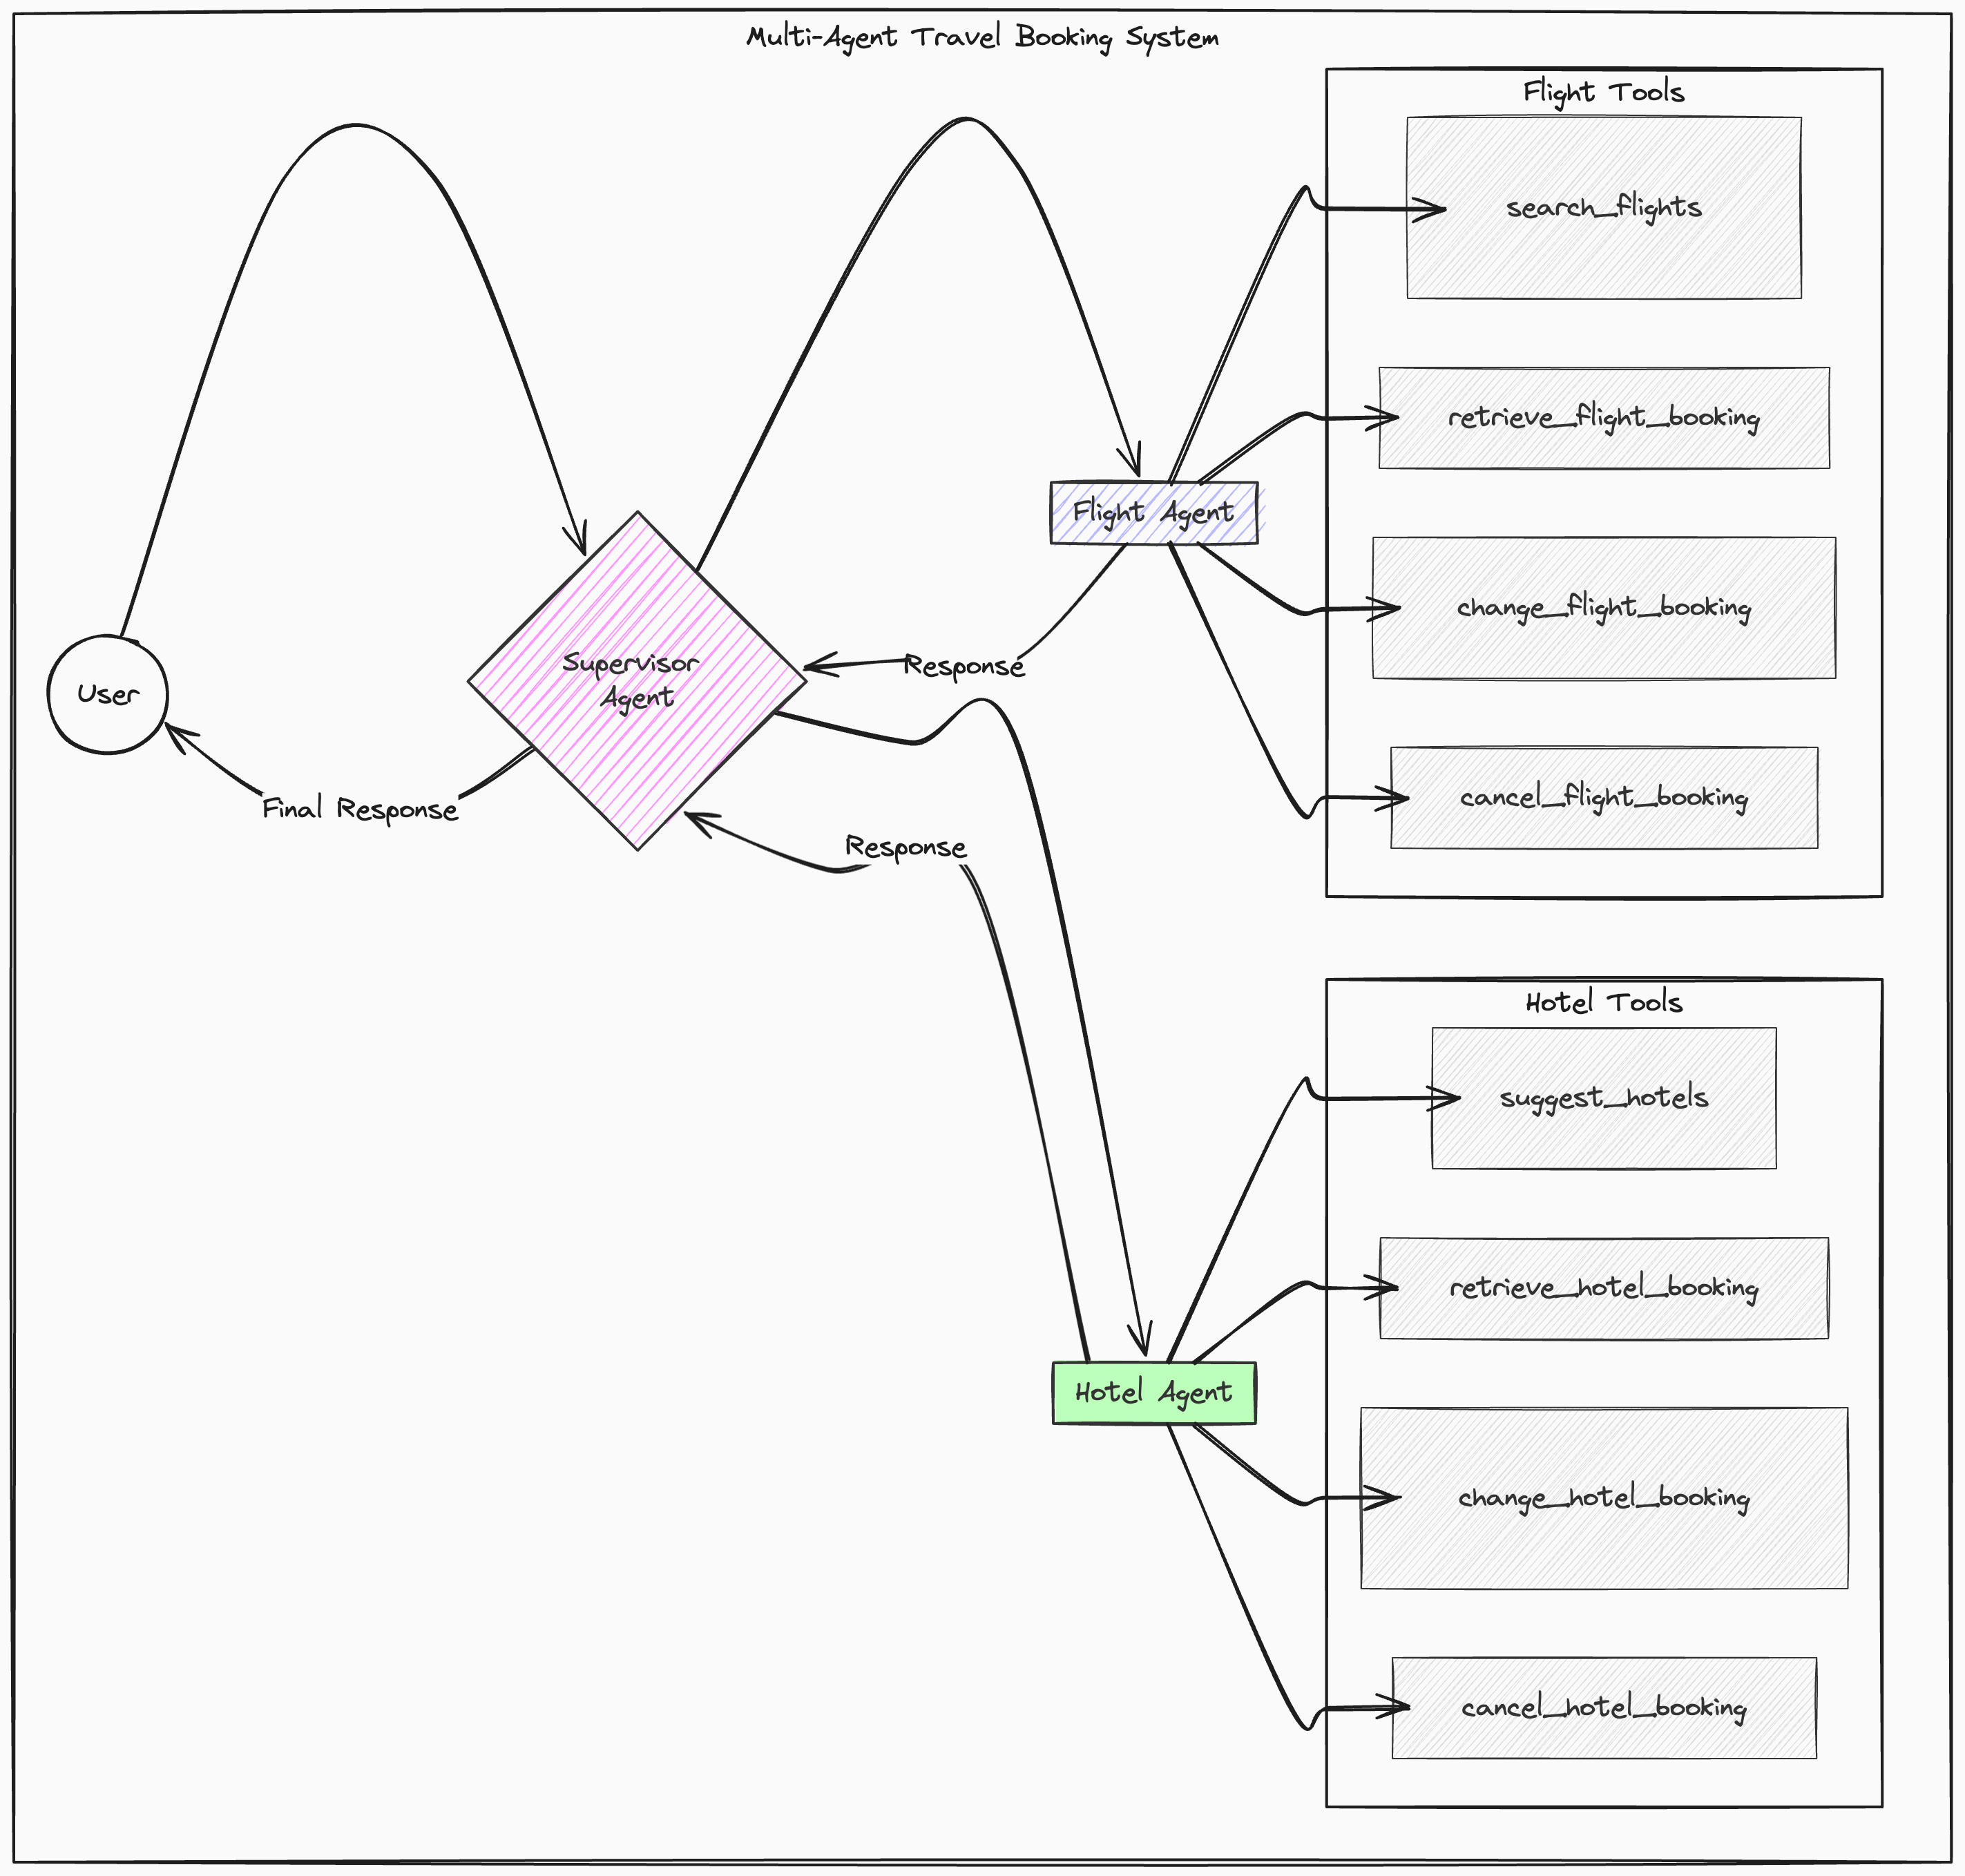

## Flight agent

The flight agent is designed to handle various tasks related to flight booking management. It utilizes a set of  tools to perform operations such as searching for available flights, retrieving detailed booking information, modifying existing flight bookings, and canceling reservations. By leveraging these tools, the flight agent can efficiently manage flight-related queries and actions. 

The flight agent is equipped with a variety of tools.

These tools include:
- **Flight Search Tool**: Allows users to search for available flights between specified cities on a given date. It provides detailed information about airlines, departure and arrival times, flight duration, and pricing.
  
- **Booking Retrieval Tool**: Enables the retrieval of detailed booking information using a booking ID. This tool is essential for users who need to review or confirm their flight details.
  
- **Booking Modification Tool**: Offers the capability to modify existing flight bookings. Users can change flight dates, times, or even cancel reservations if needed.
  
- **Cancellation Tool**: Facilitates the cancellation of flight bookings, ensuring that users can manage their travel plans with ease.



### Flight Search tool

The `search_flights` function is a tool designed to search for flights between two specified cities. 

**Purpose**: This tool simulates a flight search engine, providing mock flight data for given departure and arrival cities on a specified date.

**Note**: This function is designed for demonstration and testing purposes, using randomly generated data rather than real flight information.

The tool provides a simulated flight search experience, allowing for the testing and development of flight booking systems or travel planning applications without accessing real flight data APIs.


## Setup

In [ ]:
%pip install -U --no-cache-dir  \
"langchain==0.3.7" \
"langchain-aws==0.2.6" \
"langchain-community==0.3.5" \
"langchain-text-splitters==0.3.2" \
"langchainhub==0.1.20" \
"langgraph==0.2.45" \
"langgraph-checkpoint==2.0.2" \
"langgraph-sdk==0.1.35" \
"langsmith==0.1.140" \
"pypdf==3.8,<4" \
"ipywidgets>=7,<8" \
"matplotlib==3.9.0"


In [ ]:
from langchain_core.tools import tool
import random
from datetime import datetime, timedelta
from langgraph.prebuilt import ToolNode
import sqlite3


@tool
def search_flights(departure_city: str, arrival_city: str, date: str = None) -> str:
    """
    Use this tool to search for flights between two cities

    Args:
        departure_city (str): The city of departure
        arrival_city (str): The city of arrival
        date (str, optional): The date of the flight in YYYY-MM-DD format. If not provided, defaults to 7 days from now.

    Returns:
        str: A formatted string containing flight information including airline, departure time, arrival time, duration, and price for multiple flights.
    """
    departure_city = departure_city.capitalize()
    arrival_city = arrival_city.capitalize()

    if date is None:
        date = (datetime.now() + timedelta(days=7)).strftime("%Y-%m-%d")

    # Generate mock flight data
    num_flights = random.randint(2, 5)
    airlines = ["AirEurope", "SkyWings", "TransContinental", "EuroJet", "GlobalAir"]
    flights = []

    for _ in range(num_flights):
        airline = random.choice(airlines)
        duration = timedelta(minutes=2)
        price = random.randint(100, 400)
        departure_time = datetime.strptime(date, "%Y-%m-%d") + timedelta(
            hours=random.randint(0, 23), minutes=random.randint(0, 59)
        )
        arrival_time = departure_time + duration

        flights.append(
            {
                "airline": airline,
                "departure": departure_time.strftime("%H:%M"),
                "arrival": arrival_time.strftime("%H:%M"),
                "duration": str(duration),
                "price": price,
            }
        )

    # Format the results
    import json

    flight_data = {
        "departure_city": departure_city,
        "arrival_city": arrival_city,
        "date": date,
        "flights": []
    }
    for i, flight in enumerate(flights, 1):
        flight_info = {
            "flight_number": i,
            "airline": flight['airline'],
            "departure": flight['departure'],
            "arrival": flight['arrival'],
            "duration": str(flight['duration']),
            "price": flight['price']
        }
        flight_data["flights"].append(flight_info)

    return json.dumps(flight_data) + " FINISHED"


### Flight Booking Retrieval Tool

The `retrieve_flight_booking` function is a tool designed to fetch flight booking information from a database. 

**Purpose**: This tool retrieves flight booking details based on a provided booking ID

**Note**: This function is designed to work with a specific database schema, assuming a 'flight_bookings' table exists with 'booking_id' as a field.


In [ ]:
@tool
def retrieve_flight_booking(booking_id: int) -> str:
    """
    Retrieve a flight booking by ID

    Args:
        booking_id (int): The unique identifier of the booking to retrieve

    Returns:
        str: A string containing the booking information if found, or a message indicating no booking was found
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()

    # Execute the query to retrieve the booking
    cursor.execute("SELECT * FROM flight_bookings WHERE booking_id = ?", (booking_id,))
    booking = cursor.fetchone()

    # Close the connection
    conn.close()

    if booking:
        return f"Booking found: {booking} FINISHED"
    else:
        return f"No booking found with ID: {booking_id} FINISHED"

### Change Flight Booking Tool

The `change_flight_booking` function is a tool designed to change flight booking information in the database. 

**Purpose**: This function allows for changing the departure date of an existing flight booking.

**Note**: This function assumes the existence of a 'flight_bookings' table with 'booking_id' and 'departure_date' columns.
  

In [ ]:
@tool
def change_flight_booking(booking_id: int, new_date: str) -> str:
    """
    Change the date of a flight booking

    Args:
        booking_id (int): The unique identifier of the booking to be changed
        new_date (str): The new date for the booking

    Returns:
        str: A message indicating the result of the booking change operation
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()

    # Execute the query to update the booking date
    cursor.execute(
        "UPDATE flight_bookings SET departure_date = ? WHERE booking_id = ?",
        (new_date, booking_id),
    )
    conn.commit()

    # Check if the booking was updated
    if cursor.rowcount > 0:
        result = f"Booking updated with ID: {booking_id}, new date: {new_date} FINISHED"
    else:
        result = f"No booking found with ID: {booking_id} FINISHED"

    # Close the connection
    conn.close()

    return result 

### Flight Cancellation tool

The `cancel_flight_booking` function is a tool designed to cancel flight bookings in the database.

**Purpose**: This function is designed to cancel an existing flight booking in the system.



In [ ]:
@tool
def cancel_flight_booking(booking_id: int) -> str:
    """
    Cancel a flight booking. If the task complete, reply with "FINISHED"

    Args:
        booking_id (str): The unique identifier of the booking to be cancelled

    Returns:
        str: A message indicating the result of the booking cancellation operation

    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor  = conn.cursor()

    cursor.execute("DELETE FROM flight_bookings WHERE booking_id = ?", (booking_id,))
    conn.commit()

    # Check if the booking was deleted
    if cursor.rowcount > 0:
        result = f"Booking canceled with ID: {booking_id} FINISHED"
    else:
        result = f"No booking found with ID: {booking_id} FINISHED"

    # Close the connection
    conn.close()

    return result

### Language Model

The LLM powering all of our agent implementations in this lab will be Claude 3 Sonnet via Amazon Bedrock. For easy access to the model we are going to use ChatBedrockConverse class of LangChain, which is a wrapper around Bedrock's Converse API.

In [ ]:
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-2")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

### Flight Agent setup

We are going to use `create_react_agent` to create a flight agent. This is a prebuilt component from LangGraph build the agent with tools. We can also build it from scratch but we to keep it simple we will use the prebuilt one.

We can customize the prompt using `state_modifier`

In our case, the flight agent uses this framework to:
- Interpret user queries about flights
- Decide which tool (search, retrieve, change, or cancel) to use
- Execute the chosen tool and interpret the results
- Formulate responses based on the tool outputs


In [ ]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

memory = MemorySaver()


flight_agent = create_react_agent(
    llm,
    tools=[
        search_flights,
        retrieve_flight_booking,
        change_flight_booking,
        cancel_flight_booking,
    ],
    state_modifier="""
    First gather all the information required to call a tool. 
    If you are not able to find the booking the do not try again and just reply with "FINISHED". 
    If tool has returned the results then reply with "FINISHED"
    If all tasks are complete, reply with "FINISHED"
    """,
    checkpointer=memory,
)

In [ ]:
from IPython.display import Image, display

display(Image(flight_agent.get_graph().draw_mermaid_png()))

### Testing the Flight Agent

Let's put the flight agent to the test with a sample query.

In [ ]:
config = {"configurable": {"thread_id": "123"}}
flight_agent.invoke({"messages": [("user", "Can you give me booking details of booking number 10")]}, config)

## Hotel Agent

Just like flight agent we need to create few tools, which can manage hotel bookings. We will use the same approach as we did with flight agents. 

The Hotel Agent will be responsible for handling various hotel-related tasks, including:
 1. Suggesting hotels based on city and check-in date
 2. Retrieving hotel booking details
 3. Modifying existing hotel bookings
 4. Cancelling hotel reservations
 
 These functionalities will be implemented as separate tools, similar to the Flight Agent. The Hotel Agent will use these tools to interact with a simulated hotel booking system.



### Suggest hotel tool

The `suggest_hotels` function is a tool designed to suggest hotels based on city and check-in date. It takes in a city name (e.g., "New York") and a check-in date (e.g., 2019-08-30) as input, and returns a list of suggested hotel names.

**Purpose**: This tool simulates a hotel booking system that suggests hotels based on city and check-in date.

**Note**: This function is designed for demonstration and testing purposes, using randomly generated data rather than real information from hotel booking system.


In [ ]:
@tool
def suggest_hotels(city: str, checkin_date: str) -> dict:
    """
    Use this tool to search for hotels in these cities

    Args:
        city (str): The name of the city to search for hotels
        checkin_date (str): The check-in date in YYYY-MM-DD format

    Returns:
        dict: A dictionary containing:
            - hotels (list): List of hotel names in the specified city
            - checkin_date (str): The provided check-in date
            - checkout_date (str): A randomly generated checkout date
            - price (int): A randomly generated price for the stay
    """
    hotels = {
        "New York": ["Hotel A", "Hotel B", "Hotel C"],
        "Paris": ["Hotel D", "Hotel E", "Hotel F"],
        "Tokyo": ["Hotel G", "Hotel H", "Hotel I"],
    }

    # Generate random checkout date and price
    checkin = datetime.strptime(checkin_date, "%Y-%m-%d")
    checkout = checkin + timedelta(days=random.randint(1, 10))
    price = random.randint(100, 500)

    hotel_list = hotels.get(city, ["No hotels found"])
    return {
        "hotels": hotel_list,
        "checkin_date": checkin_date,
        "checkout_date": checkout.strftime("%Y-%m-%d"),
        "price": price,
    }

### Hotel Booking Retrieval Tool

The `retrieve_hotel_booking` function is a tool designed to fetch hotel booking information from a database. 

**Purpose**: This tool retrieves hotel booking details based on a provided booking ID

**Note**: This function is designed to work with a specific database schema, assuming a 'hotel_bookings' table exists with 'booking_id' as a field.

In [ ]:
@tool
def retrieve_hotel_booking(booking_id: int) -> str:
    """
    Retrieve a hotel booking by ID

    Args:
        booking_id (int): The unique identifier of the hotel booking to retrieve

    Returns:
        str: A string containing the hotel booking information if found, or a message indicating no booking was found
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM hotel_bookings WHERE booking_id='{booking_id}'")
    booking = cursor.fetchone()

    # Close the connection
    conn.close()

    if booking:
        return f"Booking found: {booking}"
    else:
        return f"No booking found with ID: {booking_id}"

### Change Hotel Booking Tool

The `change_hotel_booking` function is a tool designed to change hotel booking information in the database. 

**Purpose**: This function allows for changing the new checkin and checkout date for the existing booking in the database.

**Note**: This function assumes the existence of a 'hotel_bookings' table with 'booking_id' and 'check_in_date' columns.

In [ ]:
from datetime import datetime

@tool
def change_hotel_booking(
    booking_id: int, new_checkin_date: str = None, new_checkout_date: str = None
) -> str:
    """
    Change the dates of a hotel booking in the database

    Args:
    booking_id (int): The unique identifier of the booking to be changed
    new_checkin_date (str, optional): The new check-in date in YYYY-MM-DD format
    new_checkout_date (str, optional): The new check-out date in YYYY-MM-DD format

    Returns:
    str: A message indicating the result of the booking change operation
    """

    conn = sqlite3.connect("data/travel_bookings.db")  # Replace with your actual database file
    cursor = conn.cursor()

    try:
        # First, fetch the current booking details
        cursor.execute(
            """
            SELECT * FROM hotel_bookings WHERE booking_id = ?
        """,
            (booking_id,),
        )

        booking = cursor.fetchone()

        if booking is None:
            return f"No hotel booking found with ID: {booking_id}"

        # Unpack the booking details
        (
            _,
            user_id,
            user_name,
            city,
            hotel_name,
            check_in_date,
            check_out_date,
            nights,
            price_per_night,
            total_price,
            num_guests,
            room_type,
        ) = booking

        # Update check-in and check-out dates if provided
        if new_checkin_date:
            check_in_date = new_checkin_date
        if new_checkout_date:
            check_out_date = new_checkout_date

        # Recalculate nights and total price
        checkin = datetime.strptime(check_in_date, "%Y-%m-%d")
        checkout = datetime.strptime(check_out_date, "%Y-%m-%d")
        nights = (checkout - checkin).days
        total_price = nights * price_per_night

        # Update the booking in the database
        cursor.execute(
            """
            UPDATE hotel_bookings
            SET check_in_date = ?, check_out_date = ?, nights = ?, total_price = ?
            WHERE booking_id = ?
        """,
            (check_in_date, check_out_date, nights, total_price, booking_id),
        )

        conn.commit()

        return f"Hotel booking updated: Booking ID {booking_id}, New check-in: {check_in_date}, New check-out: {check_out_date}, Nights: {nights}, Total Price: {total_price}"

    except sqlite3.Error as e:
        conn.rollback()
        return f"An error occurred: {str(e)}"

    finally:
        conn.close()

### Hotel Cancellation tool

The `cancel_hotel_booking` function is a tool designed to cancel hotel bookings in the database.

**Purpose**: This function is designed to cancel an existing hotel booking in the system.

In [ ]:
@tool
def cancel_hotel_booking(booking_id: int) -> str:
    """
    Cancel a hotel booking. If the task completes, reply with "FINISHED"

    Args:
        booking_id (str): The unique identifier of the booking to be cancelled

    Returns:
        str: A message indicating the result of the booking cancellation operation
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor  = conn.cursor()

    cursor.execute("DELETE FROM hotel_bookings WHERE booking_id = ?", (booking_id,))
    conn.commit()

    # Check if the booking was deleted
    if cursor.rowcount > 0:
        result = f"Booking canceled with ID: {booking_id}"
    else:
        result = f"No booking found with ID: {booking_id}"

    # Close the connection
    conn.close()

    return result


## Hotel agent 

So far we have seen how to create agent using `create_react_agent` class of LangGraph, which has simplified things for us. But we need human confirmation before changing hotel booking or before cancelling hotel booking. We need our agent to ask ask for confirmation before executing these tools. We will create a custom agent that can handle these things. We will create a separate node that can handel booking cancellation or modification. Agent execution will be interrupted at this node to get the confirmation. 

### Hotel Booking Assistant Setup

The `hotel_agent` class is a custom implementation for managing hotel bookings. It extends the functionality of a standard LangChain agent by adding the ability to ask for additional information from the user when needed. 

This code sets up a hotel booking assistant using LangChain components. It includes:

-  `hotel_agent` class that manages interactions with the language model.
- prompt template for the primary assistant, focused on hotel bookings.
- set of hotel-related tools for tasks like suggesting hotels and managing bookings.
- runnable object that combines the prompt, language model, and tools.

The assistant can handle hotel inquiries, make suggestions, and perform booking operations.
It also has the ability to ask for additional information when needed.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant who manage hotel bookings"
            
        ),
        ("placeholder", "{messages}"),
    ]
)
hotel_tools = [
    suggest_hotels,
    retrieve_hotel_booking,
    change_hotel_booking,
    cancel_hotel_booking,
]

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(
    hotel_tools
)


def hotel_agent(state: State):
    return {"messages": [runnable_with_tools.invoke(state)]}

Now we will create 2 separate nodes for `search_and_retrieve_node` and `change_and_cancel_node`, so that we can interrupt for human approval when `change_and_cancel_node` is executed.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class HumanApprovalToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
            if user_input.lower() == "y":
                tool_result = self.tools_by_name[tool_call["name"]].invoke(
                    tool_call["args"]
                )
                outputs.append(
                    ToolMessage(
                        content=json.dumps(tool_result),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
            else:
                outputs.append(
                    ToolMessage(
                        content=f"API call denied by user. Reasoning: '{user_input}'. ",
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
        return {"messages": outputs}

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition


search_and_retrieve_node = ToolNode([suggest_hotels, retrieve_hotel_booking])
change_and_cancel_node = HumanApprovalToolNode(
    [change_hotel_booking, cancel_hotel_booking]
)

We need to check which node is executed next. This function can check the state and decide which node to execute next of end the execution.

In [ ]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    elif last_message.tool_calls[0]["name"] in [
        "change_hotel_booking",
        "cancel_hotel_booking",
    ]:
        return "human_approval"
    # Otherwise if there is, we continue
    else:
        return "continue"

### Assembling the Hotel Agent Graph

Let's add all the nodes in the graph and compile it to create our custom hotel agent.

This graph will define the flow of our hotel booking system, including:

1. The main hotel agent node for processing requests
2. A tool node for executing search and retrieve hotel booking
3. Another tool node for cancelling and changing hotel booking

The graph will use conditional edges to determine the next step based on the current state, allowing for a dynamic and responsive workflow. We'll also set up memory management to maintain state across interactions.

In [ ]:
from langgraph.graph import END, StateGraph, MessagesState
from IPython.display import Image, display

# Create a new graph workflow
hotel_workflow = StateGraph(MessagesState)

hotel_workflow.add_node("hotel_agent", hotel_agent)
hotel_workflow.add_node("search_and_retrieve_node", search_and_retrieve_node)
hotel_workflow.add_node("change_and_cancel_node", change_and_cancel_node)

hotel_workflow.add_edge(START, "hotel_agent")

# We now add a conditional edge
hotel_workflow.add_conditional_edges(
    "hotel_agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If agent decides to use `suggest_hotels` or  `retrieve_hotel_booking`
        "continue": "search_and_retrieve_node",
        # If agent decides to use `change_hotel_booking` or  `cancel_hotel_booking`
        "human_approval": "change_and_cancel_node",
        "end": END,
    },
)


hotel_workflow.add_edge("search_and_retrieve_node", "hotel_agent")
hotel_workflow.add_edge("change_and_cancel_node", "hotel_agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

hotel_graph_compiled = hotel_workflow.compile(
    checkpointer=memory
)

display(Image(hotel_graph_compiled.get_graph().draw_mermaid_png()))

### Testing the Custom Hotel Agent

Now we can test this agent that we have created from scratch.

In [ ]:
import uuid
from langchain_core.messages import ToolMessage
thread_id = str(uuid.uuid4())

_printed = set()
config = {"configurable": {"thread_id": thread_id}}

events = hotel_graph_compiled.stream(
    {"messages": ("user", "Get details of my booking id 203")},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
thread_id = str(uuid.uuid4())

config = {"configurable": {"thread_id": thread_id}}

events = hotel_graph_compiled.stream(
    {"messages": ("user", "cancel my hotel booking id 206")},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

## Supervisor agent

Now its time to create supervisor agent that will be in charge of deciding which child agent to call based on the user input and based on the conversation history. 


The Supervisor Agent is responsible for:
1. Analyzing the conversation history and user input
2. Deciding which child agent (flight_agent or hotel_agent) to call next
3. Determining when to finish the conversation
   
We will create this agent with LangChain runnable chain created using supervisor prompt. We need to get the `next_step` from the chain and we use `with_structured_output` to return next step.

The Supervisor Agent  routes  tasks and maintains the overall flow of the conversation between the user and child agents.

In [ ]:
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence, List
from langchain_core.messages import HumanMessage

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core import __version__ as core_version
from packaging import version

core_version = version.parse(core_version)
if (core_version.major, core_version.minor) < (0, 3):
    from pydantic.v1 import BaseModel
else:
    from pydantic import BaseModel
from typing import Literal

members = ["flight_agent", "hotel_agent"]
options = ["FINISH"] + members

class routeResponse(BaseModel):
    """
    Return next agent name.
    """
    next: Literal[*options]


class AskHuman(BaseModel):
    """Ask missing information from the user"""

    question: str


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
        Given the conversation below who should act next?
        1. To search or cancel flight return 'flight_agent'
        2. To search for hotel or cancel hotel booking return 'hotel_agent'
        3. If you have the answer return 'FINISH'
        4. When member has finished the task, and you notice FINISHED in the message then don't repeat same member again
        5. Do not return next which is not related to user query. Example if user is asking about flight then do not call 'hotel_agent'
        Or should we FINISH? ONLY return one of these {options}. Do not explain the process.
        
        """,
        ),
        ("placeholder", "{messages}"),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = prompt | llm.with_structured_output(routeResponse)

def supervisor_agent(state):
    result = supervisor_chain.invoke(state)
    output = {
        "next": result.next,
        "messages": [
            HumanMessage(
                content=f"Supervisor decided: {result.next}", name="supervisor"
            )
        ],
    }
    print(f"Supervisor output: {output}")
    return output

We can test our supervisor agent to check if it is returning correct next step based on the user input.

In [ ]:
supervisor_agent({"messages": [("user", "I want to book a flight")]})

## Assembling the Multi-Agent System

Now it's time to put all agents together in a workflow. We will start with the `supervisor`.

<!-- 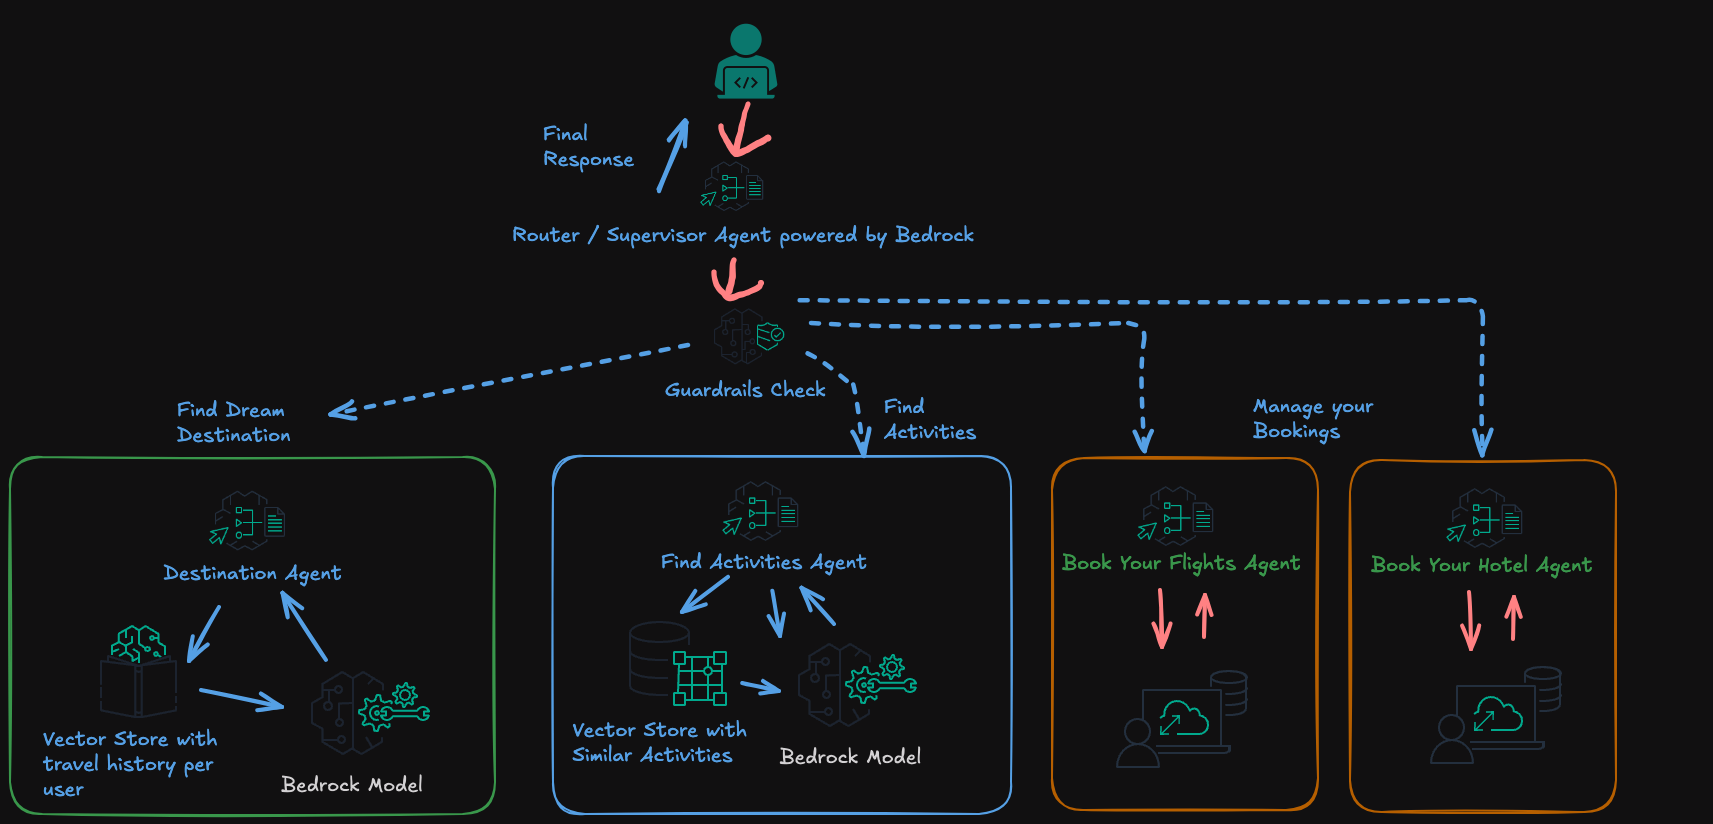 -->
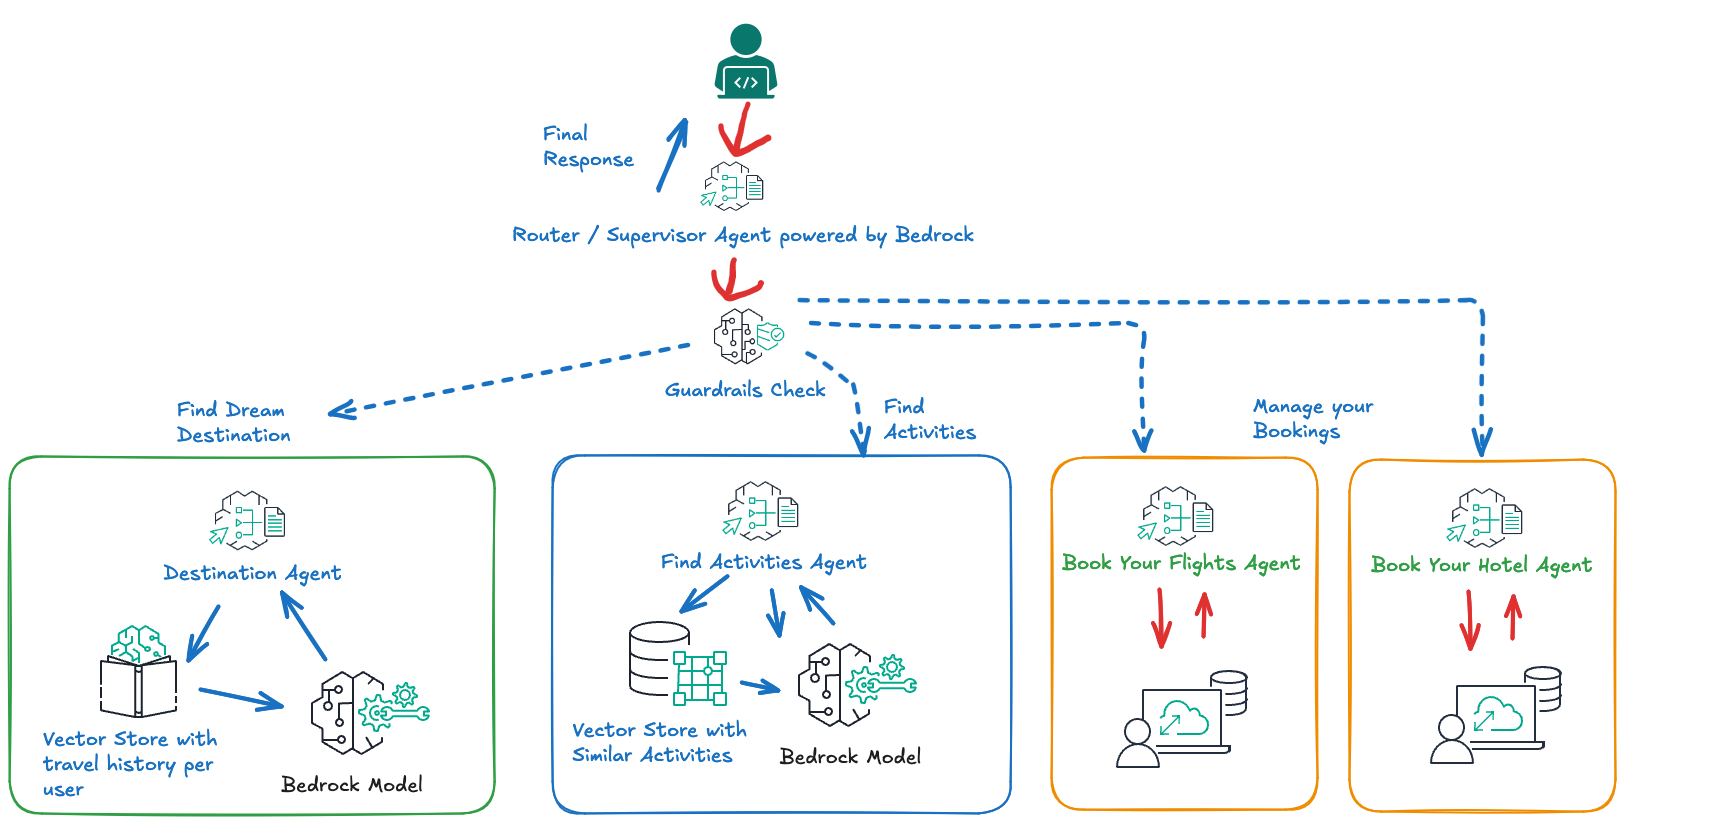

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

In [ ]:
full_workflow = StateGraph(State)
full_workflow.add_node("supervisor", supervisor_agent)

full_workflow.add_edge(START, "supervisor")


### Creating the flight agent node 

We need a helper function to take output from the flight search agent and add it to the messages list in the state. 

In [ ]:
from langchain_core.messages import AIMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [ ]:
flight_node = functools.partial(agent_node, agent=flight_agent, name="flight_agent")

Let's add this node to the workflow


In [ ]:
full_workflow.add_node("flight_agent", flight_node)

### Adding the Hotel Agent as a Subgraph

We can add `hotel_agent` as subgraph to this workflow. This is is a good example of how to use subgraphs in workflows. This also give us more control over the workflow.

In [ ]:
full_workflow.add_node("hotel_agent", hotel_graph_compiled)

Once we get the output from hotel agent we need to make sure that it has correct structure that supervisor agent can process. For this we need to add a node to the workflow that will process the output from hotel agent.

In [ ]:
def process_output(state):
    messages = state["messages"]
    for message in reversed(messages):
        if isinstance(message, AIMessage) and isinstance(message.content, str):
           print(message.content)
           return {
                "messages": [
                    HumanMessage(content=message.content, name="hotel_agent")
                ]
            }
    return None

In [ ]:

full_workflow.add_node("process_output", process_output)

### Connecting the Agents

Now we can add edges to the workflow that will connect all the agents. We need to add an edge from the flight agent to the supervisor, and from the hotel agent to the process output node and then to the supervisor.


1. We'll connect the `flight_agent` directly to the `supervisor`.
2. For the `hotel_agent`, we'll first connect it to the `process_output` node, which will format its output.
3. The `process_output` node will then be connected to the `supervisor`.
4. We'll set up conditional edges from the supervisor to all other agents (including itself) and to a FINISH state.


In [ ]:
full_workflow.add_edge("flight_agent", "supervisor")
full_workflow.add_edge("hotel_agent", "process_output")
full_workflow.add_edge("process_output", "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
full_workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

In [ ]:
from IPython.display import Image, display

supervisor_agent_graph = full_workflow.compile(
    checkpointer=memory,
)

# display subgraph using xray=1
display(Image(supervisor_agent_graph.get_graph(xray=1).draw_mermaid_png()))

We need to create a utility function to extract tool id from the subgraph. 

In [ ]:
def extract_tool_id(pregel_task):
    # Navigate to the messages in the state
    messages = pregel_task.state.values.get("messages", [])

    # Find the last AIMessage
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            # Check if the message has tool_calls
            tool_calls = getattr(message, "tool_calls", None)
            if tool_calls:
                # Return the id of the first tool call
                return tool_calls[0]["id"]

### Testing full graph

Now we are ready to test the graph. We will create a unique thread_id to manage memory. We have few sample questions to test the graph. 

`snapshot` retrieves the current state of the supervisor agent graph, which is required to check if there are pending operations or decisions that need user input. The `snapshot.next` field is checked in the `while` loop condition to determine if there are any pending operations requiring user approval.

After getting the user input we update the state. While updating the state of subgraph, we need to make sure to pass config of subgraph - `state.tasks[0].state.config` . 

If user approves the action, we update the state and invoke the graph `supervisor_agent_graph.invoke(None, config, subgraphs=True)`

If user rejects the action, we update the state with tool message and then continue with the graph.

In [ ]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

events = supervisor_agent_graph.stream(
    {"messages": ("user", "Get details of my flight booking id 200")},
    config,
    stream_mode="values",
    subgraphs=True,
)
for event in events:
    event[1]["messages"][-1].pretty_print()

In [ ]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

events = supervisor_agent_graph.stream(
    {"messages": ("user", "cancel my hotel booking id 136")},
    config,
    stream_mode="values",
    subgraphs=True,
)
for event in events:
    event[1]["messages"][-1].pretty_print()


## Conclusion

In this lab we have seen implementation of a multi-agent system for travel booking using LangGraph. The implementation showcases several key concepts:

1. **Multi-Agent Architecture**: The system effectively divides responsibilities between specialized agents (Flight and Hotel agents) coordinated by a Supervisor agent, demonstrating how complex tasks can be broken down into manageable components

2. **Subgraph Pattern**: The Hotel agent implementation as a subgraph shows how complex agent behaviors can be encapsulated and managed independently, while still integrating seamlessly with the larger system

3. **Tool Integration**: Each agent has access to specific tools relevant to its domain, showing how specialized capabilities can be effectively distributed across different agents

4. **Supervisor Pattern**: The supervisor agent demonstrates effective orchestration of multiple specialized agents, making decisions about task routing and completion

5. **State Management**: The implementation shows how to manage state across multiple agents and handle complex interactions between them

Key benefits of this approach include:
- Improved modularity and maintainability
- Better separation of concerns
- Efficient handling of domain-specific tasks
- Flexible architecture that can be extended with additional agents

This pattern can be adapted for various complex applications where multiple specialized agents need to work together to accomplish a larger goal.